In [180]:
import zipfile
from pathlib import Path
import pandas as pd

# 1. Definir rutas base
BASE_DIR = Path().resolve()
ZIP_DIR = BASE_DIR / "datos_zip"
EXTRAIDOS_DIR = BASE_DIR / "datos_extraidos"

# 2. Detectar ZIPs
zips = list(ZIP_DIR.glob("*.zip"))
print(f"Se encontraron {len(zips)} archivos ZIP en '{ZIP_DIR.name}'.")

# 3. Extraer si es necesario
for zip_path in zips:
    nombre_limpio = zip_path.stem.strip().replace(" ", "_").replace("__", "_").replace("1", "")
    destino = EXTRAIDOS_DIR / nombre_limpio

    if not destino.exists():
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destino)
        print(f"✅ Extraído: {nombre_limpio}")
    else:
        print(f"🟡 Ya extraído: {nombre_limpio}")


# 4. Cargar CSVs detectando carpetas "CSV/" anidadas
datos = {}

for mes_dir in EXTRAIDOS_DIR.iterdir():
    if not mes_dir.is_dir():
        continue

    mes = mes_dir.name
    carpeta_csv = None

    # Buscar la carpeta "CSV" más profunda con archivos CSV dentro
    for subdir in mes_dir.rglob("CSV"):
        csvs = list(subdir.glob("*.csv"))
        if csvs:
            carpeta_csv = subdir
            break

    if carpeta_csv:
        archivos = list(carpeta_csv.glob("*.csv"))
        datos[mes] = {
            f.stem.strip(): pd.read_csv(f, encoding="latin1", sep=";", low_memory=False)
            for f in archivos
        }
        print(f"📁 {mes}: {len(datos[mes])} tablas cargadas")
    else:
        print(f"⚠️ No se encontraron archivos CSV en: {mes_dir}")


Se encontraron 0 archivos ZIP en 'datos_zip'.
📁 Diciembre_2024: 8 tablas cargadas
📁 Febrero_2024: 8 tablas cargadas
📁 Julio_2024: 8 tablas cargadas
📁 Septiembre_2024: 8 tablas cargadas


FEBRERO

In [181]:
mes_febrero = datos["Febrero_2024"]
febrero_ocupados = mes_febrero["Ocupados"]
febrero_otras_formas_de_trabajo = mes_febrero["Otras formas de trabajo"]
febrero_caracteristicas_generales = mes_febrero["Características generales, seguridad social en salud y educación"]
febrero_datos_del_hogar = mes_febrero["Datos del hogar y la vivienda"]
febrero_migracion = mes_febrero["Migración"]
febrero_otros_ingresos_e_impuestos = mes_febrero["Otros ingresos e impuestos"]

In [182]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
febrero_otras_formas_de_trabajo = limpiar(febrero_otras_formas_de_trabajo)
febrero_caracteristicas_generales = limpiar(febrero_caracteristicas_generales)
febrero_migracion = limpiar(febrero_migracion)
febrero_otros_ingresos_e_impuestos = limpiar(febrero_otros_ingresos_e_impuestos)

In [183]:
df_merged1 = febrero_ocupados.merge(febrero_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged1 = df_merged1.merge(febrero_caracteristicas_generales, on=columnas_clave, how='left')
df_merged1 = df_merged1.merge(febrero_migracion, on=columnas_clave, how='left')
df_merged1 = df_merged1.merge(febrero_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [184]:
df_merged1.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240205,2,2024,7685523,1,2,1,60,50.0,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240205,2,2024,7685524,1,1,1,60,50.0,1,...,0.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240205,2,2024,7685524,1,2,1,60,50.0,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [185]:
df_merged1.shape  # Número de filas y columnas
df_merged1.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29943 entries, 0 to 29942
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 98.9+ MB


In [186]:
df_merged1.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.994300e+04,29943.0,29943.0,2.994300e+04,29943.000000,29943.000000,29943.000000,29943.0,22105.000000,29943.000000,...,4.328000e+03,29943.000000,2.465000e+03,29943.000000,9.330000e+02,933.000000,933.000000,9.330000e+02,29943.000000,5.200000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024021e+07,2.0,2024.0,7.699516e+06,1.010954,1.799719,1.010954,60.0,41.636327,1.122366,...,9.164903e+04,1.926093,5.157285e+05,1.989413,2.000469e+06,1.007503,2022.209003,1.909982e+06,2.007614,2.477248e+06
std,1.513751e+00,0.0,0.0,8.181095e+03,0.131327,1.165572,0.131327,0.0,27.060275,0.327713,...,4.585622e+06,0.368480,9.225204e+05,0.418402,1.986853e+07,0.170040,0.757115,1.981361e+07,0.259111,7.475820e+06
min,2.024020e+07,2.0,2024.0,7.685523e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2003.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024021e+07,2.0,2024.0,7.692324e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.000000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,9.590000e+04
50%,2.024021e+07,2.0,2024.0,7.699406e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,2.980000e+05,2.000000,9.800000e+01,1.000000,2022.000000,9.800000e+01,2.000000,6.250000e+05
75%,2.024021e+07,2.0,2024.0,7.706471e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,5.500000e+05,2.000000,6.000000e+05,1.000000,2022.000000,6.000000e+05,2.000000,1.575000e+06


In [187]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged1.isnull().sum().sort_values(ascending=False)

P6080S1A1      29943
P3374S3        29942
P3096S2        29942
P3096S3        29942
P6780S1        29942
P3096S1        29942
P3086S1        29941
P7028S1        29939
P3087S1        29938
P750S3         29936
P750S3A1       29936
P6430S1        29934
P6765S1        29933
P3086          29932
P3088          29932
P3087          29932
P3085          29932
P3083S1        29932
P3084S2        29932
P3082S3A1      29928
P3082S3A2      29928
P6915S1        29927
P6630S6A1      29926
P3081S3A2      29924
P3081S3A1      29924
P3055S1        29922
P750S1         29922
P750S1A1       29921
P3079S3A2      29916
P3079S3A1      29916
P3374S2        29909
P6880S1        29908
P3091S2        29904
P3091S1        29904
P3386S1        29896
P3082S2A1      29895
P3078S3A1      29895
P3078S3A2      29895
P3082S2A2      29895
P3089S2        29894
P3089S3        29894
P3089S1        29894
P3076S3A2      29891
P3076S3A1      29891
P3372S1        29891
P3077S3A1      29878
P3077S3A2      29878
P3093S1      

JULIO

In [188]:
mes_julio = datos["Julio_2024"]
julio_ocupados = mes_julio["Ocupados"]
julio_otras_formas_de_trabajo = mes_julio["Otras formas de trabajo"]
julio_caracteristicas_generales = mes_julio["Características generales, seguridad social en salud y educación"]
julio_datos_del_hogar = mes_julio["Datos del hogar y la vivienda"]
julio_migracion = mes_julio["Migración"]
julio_otros_ingresos_e_impuestos = mes_julio["Otros ingresos e impuestos"]

In [189]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
julio_otras_formas_de_trabajo = limpiar(julio_otras_formas_de_trabajo)
julio_caracteristicas_generales = limpiar(julio_caracteristicas_generales)
julio_migracion = limpiar(julio_migracion)
julio_otros_ingresos_e_impuestos = limpiar(julio_otros_ingresos_e_impuestos)

In [190]:
df_merged2 = julio_ocupados.merge(julio_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(julio_caracteristicas_generales, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(julio_migracion, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(julio_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [191]:
df_merged2.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240730,7,2024,7858603,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240730,7,2024,7858603,1,3,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240730,7,2024,7858604,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [192]:
df_merged2.shape  # Número de filas y columnas
df_merged2.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29929 entries, 0 to 29928
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 98.9+ MB


In [193]:
df_merged2.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.992900e+04,29929.0,29929.0,2.992900e+04,29929.000000,29929.000000,29929.000000,29929.0,21794.000000,29929.000000,...,4.284000e+03,29929.000000,2.475000e+03,29929.000000,8.690000e+02,869.000000,869.000000,8.690000e+02,29929.000000,4.700000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024073e+07,7.0,2024.0,7.873378e+06,1.007819,1.781984,1.007819,60.0,41.314490,1.128938,...,1.508601e+04,1.925256,5.498864e+05,1.987103,1.305435e+06,1.009206,2022.217491,1.124058e+06,2.006148,5.203676e+06
std,1.172274e+00,0.0,0.0,8.986423e+03,0.104075,1.121293,0.104075,0.0,26.977428,0.335137,...,1.497101e+05,0.364388,1.114538e+06,0.376618,5.739994e+06,0.172827,1.046111,5.283259e+06,0.235717,2.486653e+07
min,2.024073e+07,7.0,2024.0,7.858603e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2002.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024073e+07,7.0,2024.0,7.865661e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.100000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,1.100000e+05
50%,2.024073e+07,7.0,2024.0,7.872773e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.800000e+01,1.000000,2022.000000,9.800000e+01,2.000000,5.000000e+05
75%,2.024073e+07,7.0,2024.0,7.881967e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,5.820000e+05,2.000000,6.000000e+05,1.000000,2023.000000,5.000000e+05,2.000000,1.275000e+06


In [194]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged2.isnull().sum().sort_values(ascending=False)

P6080S1A1      29929
P3374S3        29928
P3096S1        29927
P3096S2        29927
P3096S3        29927
P6780S1        29926
P7028S1        29925
P3086S1        29924
P3087S1        29923
P750S3         29922
P750S3A1       29922
P3081S3A1      29915
P6630S6A1      29915
P6765S1        29915
P3081S3A2      29915
P6430S1        29914
P3055S1        29913
P6915S1        29912
P3087          29909
P3083S1        29909
P3082S3A2      29909
P3088          29909
P3084S2        29909
P3086          29909
P3085          29909
P3082S3A1      29909
P3079S3A2      29908
P3079S3A1      29908
P6585S4A2      29907
P6585S4A1      29907
P750S1A1       29900
P750S1         29900
P3091S2        29896
P3091S1        29896
P3374S2        29889
P3078S3A1      29888
P3078S3A2      29888
P3076S3A1      29886
P3076S3A2      29886
P3372S1        29882
P6880S1        29880
P3093S2        29878
P3089S1        29878
P3089S2        29878
P3093S1        29878
P3089S3        29878
P1661S2        29870
P1661S2A1    

SEPTIEMBRE

In [195]:
mes_septiembre = datos["Septiembre_2024"]
septiembre_ocupados = mes_septiembre["Ocupados"]
septiembre_otras_formas_de_trabajo = mes_septiembre["Otras formas de trabajo"]
septiembre_caracteristicas_generales = mes_septiembre["Características generales, seguridad social en salud y educación"]
septiembre_datos_del_hogar = mes_septiembre["Datos del hogar y la vivienda"]
septiembre_migracion = mes_septiembre["Migración"]
septiembre_otros_ingresos_e_impuestos = mes_septiembre["Otros ingresos e impuestos"]

In [196]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
septiembre_otras_formas_de_trabajo = limpiar(septiembre_otras_formas_de_trabajo)
septiembre_caracteristicas_generales = limpiar(septiembre_caracteristicas_generales)
septiembre_migracion = limpiar(septiembre_migracion)
septiembre_otros_ingresos_e_impuestos = limpiar(septiembre_otros_ingresos_e_impuestos)

In [197]:
df_merged3 = septiembre_ocupados.merge(septiembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged3 = df_merged3.merge(septiembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged3 = df_merged3.merge(septiembre_migracion, on=columnas_clave, how='left')
df_merged3 = df_merged3.merge(septiembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [198]:
df_merged3.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240939,9,2024,7953223,1,2,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240939,9,2024,7953224,1,1,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240939,9,2024,7953224,1,2,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [199]:
df_merged3.shape  # Número de filas y columnas
df_merged3.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29383 entries, 0 to 29382
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 97.1+ MB


In [200]:
df_merged3.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.938300e+04,29383.0,29383.0,2.938300e+04,29383.000000,29383.000000,29383.000000,29383.0,21605.000000,29383.000000,...,4.273000e+03,29383.000000,2.492000e+03,29383.000000,9.010000e+02,901.000000,901.000000,9.010000e+02,29383.000000,4.400000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024094e+07,9.0,2024.0,7.967258e+06,1.008508,1.753089,1.008508,60.0,41.437676,1.125515,...,1.051969e+04,1.923289,5.137550e+05,1.990301,2.274079e+06,1.005549,2022.771365,1.527588e+06,2.006364,9.400863e+05
std,1.175388e+00,0.0,0.0,8.183478e+03,0.115487,1.077610,0.115487,0.0,27.094060,0.331307,...,1.165328e+05,0.368280,1.561572e+06,0.421103,2.480775e+07,0.088017,0.420187,1.045141e+07,0.237678,1.456501e+06
min,2.024094e+07,9.0,2024.0,7.953223e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,1.000000,9.800000e+01
25%,2.024094e+07,9.0,2024.0,7.960186e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.050000e+05,2.000000,0.000000e+00,1.000000,2023.000000,0.000000e+00,2.000000,3.002475e+04
50%,2.024094e+07,9.0,2024.0,7.967299e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.800000e+01,1.000000,2023.000000,9.800000e+01,2.000000,5.100000e+05
75%,2.024094e+07,9.0,2024.0,7.974474e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,5.600000e+05,2.000000,5.500000e+05,1.000000,2023.000000,4.000000e+05,2.000000,1.200000e+06


In [201]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged3.isnull().sum().sort_values(ascending=False)

P3096S1        29383
P3374S3        29383
P6080S1A1      29383
P3096S3        29383
P3096S2        29383
P6780S1        29382
P7028S1        29380
P3087S1        29380
P750S3         29378
P750S3A1       29378
P3086S1        29378
P6765S1        29374
P6430S1        29373
P6915S1        29373
P3079S3A2      29372
P3079S3A1      29372
P3082S3A1      29370
P3082S3A2      29370
P3081S3A2      29369
P3081S3A1      29369
P3091S2        29367
P3091S1        29367
P3055S1        29362
P6630S6A1      29361
P3084S2        29360
P3086          29360
P3088          29360
P3085          29360
P3083S1        29360
P3087          29360
P750S1         29357
P750S1A1       29357
P3078S3A2      29348
P3078S3A1      29348
P3093S1        29343
P3093S2        29343
P3077S3A1      29343
P3077S3A2      29343
P3386S1        29342
P3374S2        29340
P3372S1        29339
P1661S2A1      29339
P1661S2        29339
P3089S1        29338
P3089S2        29338
P3089S3        29338
P6585S4A1      29338
P6585S4A2    

DICIEMBRE

In [202]:
# DICIEMBRE
mes_diciembre = datos["Diciembre_2024"]
diciembre_ocupados = mes_diciembre["Ocupados"]
diciembre_otras_formas_de_trabajo = mes_diciembre["Otras formas de trabajo"]
diciembre_caracteristicas_generales = mes_diciembre["Características generales, seguridad social en salud y educación"]
diciembre_datos_del_hogar = mes_diciembre["Datos del hogar y la vivienda"]
diciembre_migracion = mes_diciembre["Migración"]
diciembre_otros_ingresos_e_impuestos = mes_diciembre["Otros ingresos e impuestos"]

In [203]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
diciembre_otras_formas_de_trabajo = limpiar(diciembre_otras_formas_de_trabajo)
diciembre_caracteristicas_generales = limpiar(diciembre_caracteristicas_generales)
diciembre_migracion = limpiar(diciembre_migracion)
diciembre_otros_ingresos_e_impuestos = limpiar(diciembre_otros_ingresos_e_impuestos)

In [204]:
df_merged4 = diciembre_ocupados.merge(diciembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged4 = df_merged4.merge(diciembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged4 = df_merged4.merge(diciembre_migracion, on=columnas_clave, how='left')
df_merged4 = df_merged4.merge(diciembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [205]:
df_merged4.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20241252,12,2024,8038184,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20241252,12,2024,8038186,1,2,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20241252,12,2024,8038187,1,1,1,60,NaN,2,...,0.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [206]:
df_merged4.shape  # Número de filas y columnas
df_merged4.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28154 entries, 0 to 28153
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 93.0+ MB


In [207]:
df_merged4.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.815400e+04,28154.0,28154.0,2.815400e+04,28154.000000,28154.000000,28154.000000,28154.0,20292.000000,28154.000000,...,3.888000e+03,28154.000000,2.131000e+03,28154.000000,8.740000e+02,874.000000,874.000000,8.740000e+02,28154.000000,5.000000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024125e+07,12.0,2024.0,8.058883e+06,1.005719,1.756624,1.005719,60.0,41.879115,1.131207,...,1.620084e+04,1.935249,6.243351e+05,1.995809,1.753287e+06,1.012586,2022.942792,1.491696e+06,2.003943,2.498726e+06
std,1.163032e+00,0.0,0.0,1.665923e+04,0.091184,1.095134,0.091184,0.0,27.329209,0.337633,...,2.072980e+05,0.384815,2.124965e+06,0.467974,6.896895e+06,0.194016,0.956763,5.905560e+06,0.204430,5.293809e+06
min,2.024125e+07,12.0,2024.0,8.038184e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2003.000000,0.000000e+00,1.000000,9.800000e+01
25%,2.024125e+07,12.0,2024.0,8.044952e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.300000e+05,2.000000,0.000000e+00,1.000000,2023.000000,0.000000e+00,2.000000,7.574250e+03
50%,2.024125e+07,12.0,2024.0,8.052078e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.500000e+05,2.000000,9.800000e+01,1.000000,2023.000000,9.800000e+01,2.000000,3.430000e+05
75%,2.024125e+07,12.0,2024.0,8.078221e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,6.375000e+05,2.000000,8.000000e+05,1.000000,2023.000000,7.000000e+05,2.000000,1.450000e+06


In [208]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged4.isnull().sum().sort_values(ascending=False)

P6080S1A1      28154
P3374S3        28154
P3096S2        28153
P3096S3        28153
P3096S1        28153
P6780S1        28151
P750S3         28149
P750S3A1       28149
P3087S1        28149
P3086S1        28149
P3082S3A2      28149
P3082S3A1      28149
P6430S1        28148
P7028S1        28147
P3079S3A2      28145
P3079S3A1      28145
P6765S1        28145
P750S1A1       28143
P750S1         28143
P3081S3A2      28142
P3081S3A1      28142
P6915S1        28142
P3087          28141
P3085          28141
P3083S1        28141
P3084S2        28141
P3086          28141
P3088          28141
P3055S1        28136
P3082S2A2      28135
P3082S2A1      28135
P6630S6A1      28133
P6585S4A2      28128
P6585S4A1      28128
P3091S2        28126
P3091S1        28126
P3374S2        28118
P3089S3        28115
P3089S1        28115
P6880S1        28115
P3089S2        28115
P3372S1        28104
P3386S1        28101
P3077S3A1      28097
P3077S3A2      28097
P1661S2A1      28094
P1661S2        28094
P3093S2      

ANUAL

In [209]:
# Lista con los nombres de los meses
meses = ['Febrero',
         'Julio','Septiembre', 'Noviembre', 'Diciembre']

# Crear una lista con tus DataFrames y agregar columna del mes
dataframes = []
for i in range(4):
    df = globals()[f'df_merged{i+1}'].copy()  # copiar para no modificar el original
    df['MES_ORIGEN'] = meses[i]
    dataframes.append(df)

# Concatenar todos en uno solo
df_anual = pd.concat(dataframes, ignore_index=True)

In [210]:
# ---------------
# Limpieza de valores faltantes a nivel ANUAL
# 1) Eliminar columnas con >80% de valores nulos
porc_nulos_col = df_anual.isnull().mean() * 100
cols_to_drop = porc_nulos_col[porc_nulos_col > 80].index
df_anual.drop(columns=cols_to_drop, inplace=True)
print(f"Columnas eliminadas (>80% nulos): {list(cols_to_drop)}")

# 2) Eliminar filas con >70% de valores nulos
porc_nulos_fila = df_anual.isnull().mean(axis=1) * 100
filas_drop = porc_nulos_fila[porc_nulos_fila > 70].index
df_anual.drop(index=filas_drop, inplace=True)
print(f"Filas eliminadas (>70% nulos): {len(filas_drop)}")
# ---------------

Columnas eliminadas (>80% nulos): ['P6460S1', 'P6410', 'P6420S2', 'P6430S1', 'P3364S1', 'P6510S1', 'P6510S2', 'P6590S1', 'P6600S1', 'P6610S1', 'P6620S1', 'P6585S1A1', 'P6585S1A2', 'P6585S3A1', 'P6585S3A2', 'P6585S4A1', 'P6585S4A2', 'P6545S1', 'P6545S2', 'P6580S1', 'P6580S2', 'P6630S2A1', 'P6630S3A1', 'P6630S4A1', 'P6630S6A1', 'P6640S1', 'P1800S1', 'P1801S1', 'P1801S2', 'P1801S3', 'P6765S1', 'P3051', 'P3051S1', 'P3365S1', 'P3054S1', 'P3055S1', 'P3056', 'P3057', 'P6760', 'P3058S1', 'P3058S2', 'P3058S3', 'P3058S4', 'P3058S5', 'P3059', 'P3061', 'P3062S1', 'P3062S2', 'P3062S3', 'P3062S4', 'P3062S5', 'P3062S6', 'P3062S7', 'P3062S8', 'P3062S9', 'P3063', 'P3063S1', 'P3064', 'P3064S1', 'P3067', 'P3067S1', 'P3067S2', 'P6775', 'P3068', 'P550', 'P6780S1', 'P6810', 'P6810S1', 'P6830', 'P6830S1', 'P3366', 'P6880S1', 'P6915S1', 'P7028S1', 'P1880S1', 'P7045', 'P7050', 'P7070', 'P7075', 'P7077', 'P7100', 'P7110', 'P7120', 'P7140S1', 'P7140S2', 'P7140S3', 'P7140S4', 'P7140S5', 'P7140S6', 'P7140S7', 'P71

In [211]:
print(df_anual.shape)  # Ver tamaño total
print(df_anual['MES_ORIGEN'].value_counts())  # Ver cuántas filas por mes

(117409, 206)
MES_ORIGEN
Febrero       29943
Julio         29929
Septiembre    29383
Noviembre     28154
Name: count, dtype: int64


In [212]:
df_anual.head(5)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3384S2,P3384S3,P3385,P7495,P7505,P3367,P3370,P3371,P3372,MES_ORIGEN
0,20240205,2,2024,7685523,1,2,1,60,50.0,1,...,.,.,1.0,2,2,2,2,2,2,Febrero
1,20240205,2,2024,7685524,1,1,1,60,50.0,1,...,.,.,1.0,2,2,1,2,2,2,Febrero
2,20240205,2,2024,7685524,1,2,1,60,50.0,1,...,.,.,1.0,2,2,2,2,2,2,Febrero
3,20240205,2,2024,7685525,1,2,1,60,50.0,1,...,.,.,1.0,2,2,1,2,2,2,Febrero
4,20240205,2,2024,7685526,1,1,1,60,50.0,1,...,.,.,1.0,2,2,2,2,2,2,Febrero


In [213]:
list(df_anual.columns)

['PERIODO',
 'MES',
 'PER',
 'DIRECTORIO',
 'SECUENCIA_P',
 'ORDEN',
 'HOGAR',
 'REGIS',
 'AREA',
 'CLASE',
 'FEX_C18',
 'DPTO',
 'FT',
 'P3044S2',
 'P6440',
 'P6450',
 'P6460',
 'P6400',
 'P6422',
 'P6424S1',
 'P6424S2',
 'P6424S3',
 'P6424S5',
 'P6426',
 'P6430',
 'P3045S1',
 'P3045S2',
 'P3045S3',
 'P3046',
 'P3363',
 'P9440',
 'P6500',
 'P3364',
 'P6510',
 'P6590',
 'P6600',
 'P6610',
 'P6620',
 'P6585S1',
 'P6585S2',
 'P6585S2A1',
 'P6585S2A2',
 'P6585S3',
 'P6585S4',
 'P6545',
 'P6580',
 'P6630S1',
 'P6630S1A1',
 'P6630S2',
 'P6630S3',
 'P6630S4',
 'P6630S6',
 'P6640',
 'P1800',
 'P1802',
 'P3047',
 'P3048',
 'P3049',
 'P6765',
 'P3052',
 'P3052S1',
 'P3053',
 'P3365',
 'P3054',
 'P3055',
 'P3065',
 'P3066',
 'P6750',
 'P3073',
 'P6780',
 'P1879',
 'P1805',
 'P6790',
 'P6800',
 'P6850',
 'P3069',
 'P6880',
 'P6915',
 'P6920',
 'P6930',
 'P6940',
 'P6960',
 'P6990',
 'P9450',
 'P7020',
 'P760',
 'P7026',
 'P7028',
 'P1880',
 'P7040',
 'P7090',
 'P7130',
 'P7170S1',
 'P7170S5',
 'P

In [214]:
# 1. Definir el diccionario de renombramiento
col_mapping = {
    # Ingresos
    'P6500':  'ingreso_mensual',
    'P6510':  'ingreso_horas_extras',
    'P6590':  'pago_especie_alimentos',
    'P6600':  'pago_especie_vivienda',
    'P6620':  'pago_especie_otros',
    'P6585S1':'subsidio_alimentacion',
    'P6585S2':'subsidio_transporte',
    'P6585S3':'subsidio_familiar',
    'P6585S4':'subsidio_educativo',
    'P6545':  'prima_navidad',
    'P6580':  'prima_vacaciones',
    'P6630S1':'bonificacion_antiguedad',
    'P6630S2':'bonificacion_productividad',
    'P6630S3':'bonificacion_riesgo',
    'P6630S4':'bonificacion_permanencia',
    'P6630S6':'viaticos',

    # Demográficas
    'P3271':  'sexo',
    'P6040':  'edad',
    'P6080':  'etnia',
    'DPTO':   'departamento',
    'AREA':   'area_residencia',
    'CLASE':  'tipo_cabecera',

    # Educación
    'P3042':  'nivel_educativo',
    'P3042S1':'grado_nivel_educativo',
    'P3042S2':'campo_estudio',
    'P3043':  'titulo_obtenido',
    'P3043S1':'modalidad_titulo',

    # Contrato / Sector
    'P6440':  'tiene_contrato',
    'P6450':  'contrato_escrito',
    'P6460':  'tipo_contrato',
    'P3363':  'medio_obtencion_empleo',
    'P3046':  'empresa_con_contabilidad',
    'P6765':  'forma_trabajo_semana',

    # Migración
    'P3373':  'lugar_nacimiento',
    'P3374':  'nacionalidad_exterior',
    'P3382':  'residencia_5m',
    'P3383':  'residencia_12m',
    'P3384':  'residencia_5a',

    # Otros ingresos / impuestos
    'P7495':     'ingreso_arriendos_pensiones',
    'P6424S3':   'cesantias_derecho',
    'P3370':     'impuesto_predial',
    'P3371':     'impuesto_valorizacion',
    'P3372':     'impuesto_renta',
}

# 2. Verificar qué columnas no están en df_anual
faltantes = set(col_mapping.keys()) - set(df_anual.columns)
print("Columnas faltantes:", faltantes)

# 3. Filtrar las columnas que sí existen
cols_presentes = [col for col in col_mapping if col in df_anual.columns]
df_anual = df_anual[cols_presentes].copy()

# 4. Renombrar columnas existentes
col_mapping_presentes = {k: v for k, v in col_mapping.items() if k in df_anual.columns}
df_anual = df_anual.rename(columns=col_mapping_presentes)


Columnas faltantes: set()


EDA

In [215]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib seaborn

In [216]:

print("Dimensiones:", df_anual.shape)
pd.set_option('display.max_columns', None)
df_anual.head(5)


Dimensiones: (117409, 43)


,ingreso_mensual,ingreso_horas_extras,pago_especie_alimentos,pago_especie_vivienda,pago_especie_otros,subsidio_alimentacion,subsidio_transporte,subsidio_familiar,subsidio_educativo,prima_navidad,prima_vacaciones,bonificacion_antiguedad,bonificacion_productividad,bonificacion_riesgo,bonificacion_permanencia,viaticos,sexo,edad,etnia,departamento,area_residencia,tipo_cabecera,nivel_educativo,grado_nivel_educativo,campo_estudio,titulo_obtenido,modalidad_titulo,tiene_contrato,contrato_escrito,tipo_contrato,medio_obtencion_empleo,empresa_con_contabilidad,forma_trabajo_semana,lugar_nacimiento,nacionalidad_exterior,residencia_5m,residencia_12m,residencia_5a,ingreso_arriendos_pensiones,cesantias_derecho,impuesto_predial,impuesto_valorizacion,impuesto_renta
0,1800000.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1,32,6,50,50.0,1,10.0,10.0,732.0,7.0,732.0,1,1.0,NaN,1.0,1.0,NaN,1,1,2,1.0,2,2,1.0,2,2,2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,37,6,50,50.0,1,10.0,4.0,413.0,3.0,NaN,1,2.0,2.0,NaN,NaN,1.0,1,1,3,2.0,2,2,2.0,2,2,2
2,1500000.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2,38,6,50,50.0,1,5.0,2.0,NaN,2.0,NaN,1,2.0,1.0,1.0,1.0,NaN,2,1,3,2.0,2,2,1.0,2,2,2
3,6500000.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2,51,6,50,50.0,1,11.0,2.0,413.0,8.0,413.0,1,2.0,1.0,5.0,1.0,NaN,1,1,2,1.0,2,2,1.0,2,2,2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,64,6,50,50.0,1,3.0,5.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,6.0,2,1,3,1.0,2,2,NaN,2,2,2


In [217]:
df_anual.dtypes.value_counts()

float64    29
int64      14
Name: count, dtype: int64

In [218]:
num_vars = df_anual.select_dtypes(include=["int64","float64"]).columns.tolist()

print(f"Variables numéricas ({len(num_vars)}):")
for v in num_vars:
    print("  -", v)

Variables numéricas (43):
  - ingreso_mensual
  - ingreso_horas_extras
  - pago_especie_alimentos
  - pago_especie_vivienda
  - pago_especie_otros
  - subsidio_alimentacion
  - subsidio_transporte
  - subsidio_familiar
  - subsidio_educativo
  - prima_navidad
  - prima_vacaciones
  - bonificacion_antiguedad
  - bonificacion_productividad
  - bonificacion_riesgo
  - bonificacion_permanencia
  - viaticos
  - sexo
  - edad
  - etnia
  - departamento
  - area_residencia
  - tipo_cabecera
  - nivel_educativo
  - grado_nivel_educativo
  - campo_estudio
  - titulo_obtenido
  - modalidad_titulo
  - tiene_contrato
  - contrato_escrito
  - tipo_contrato
  - medio_obtencion_empleo
  - empresa_con_contabilidad
  - forma_trabajo_semana
  - lugar_nacimiento
  - nacionalidad_exterior
  - residencia_5m
  - residencia_12m
  - residencia_5a
  - ingreso_arriendos_pensiones
  - cesantias_derecho
  - impuesto_predial
  - impuesto_valorizacion
  - impuesto_renta


In [219]:
# Clasificación por tipo
tipos_vars = df_anual.dtypes
display(tipos_vars)

ingreso_mensual                float64
ingreso_horas_extras           float64
pago_especie_alimentos         float64
pago_especie_vivienda          float64
pago_especie_otros             float64
subsidio_alimentacion          float64
subsidio_transporte            float64
subsidio_familiar              float64
subsidio_educativo             float64
prima_navidad                  float64
prima_vacaciones               float64
bonificacion_antiguedad        float64
bonificacion_productividad     float64
bonificacion_riesgo            float64
bonificacion_permanencia       float64
viaticos                       float64
sexo                             int64
edad                             int64
etnia                            int64
departamento                     int64
area_residencia                float64
tipo_cabecera                    int64
nivel_educativo                float64
grado_nivel_educativo          float64
campo_estudio                  float64
titulo_obtenido          

In [230]:
num_cont_vars = [
    "ingreso_mensual"
]

num_disc_vars = [
    "edad"
]

num_vars = num_cont_vars + num_disc_vars


In [231]:
cat_vars = [
    "pago_especie_alimentos", "pago_especie_vivienda", "pago_especie_otros",
    "subsidio_alimentacion", "subsidio_transporte", "subsidio_familiar", "subsidio_educativo",
    "prima_navidad", "prima_vacaciones", "bonificacion_antiguedad",
    "bonificacion_productividad", "bonificacion_riesgo", "bonificacion_permanencia", "viaticos",
    "sexo", "etnia", "departamento", "area_residencia", "tipo_cabecera",
    "nivel_educativo", "grado_nivel_educativo", "titulo_obtenido", "modalidad_titulo",
    "tiene_contrato", "contrato_escrito", "tipo_contrato", "medio_obtencion_empleo",
    "empresa_con_contabilidad", "lugar_nacimiento", "nacionalidad_exterior",
    "residencia_5m", "residencia_12m", "residencia_5a",
    "cesantias_derecho", "impuesto_predial", "impuesto_valorizacion", "impuesto_renta" ,
    "campo_estudio", "ingreso_arriendos_pensiones","ingreso_horas_extras" , "forma_trabajo_semana"
]

TARGET: ingreso mensual
Para estimar los ingresos laborales mensuales de una persona

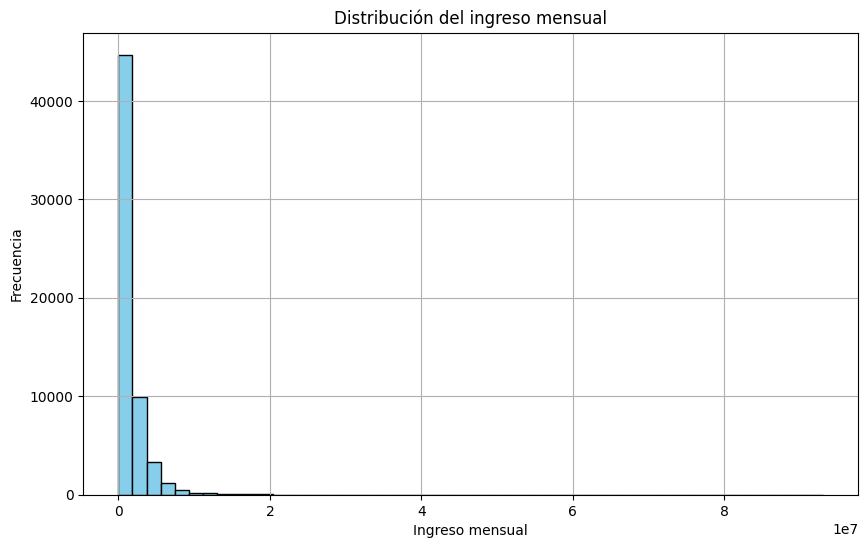

In [232]:
import matplotlib.pyplot as plt

# Histograma de ingreso mensual
plt.figure(figsize=(10, 6))
plt.hist(df_anual["ingreso_mensual"].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución del ingreso mensual")
plt.xlabel("Ingreso mensual")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

In [233]:
print(df_anual["ingreso_mensual"].describe())

count    6.034100e+04
mean     1.884619e+06
std      2.017731e+06
min      0.000000e+00
25%      1.200000e+06
50%      1.300000e+06
75%      2.000000e+06
max      9.300000e+07
Name: ingreso_mensual, dtype: float64


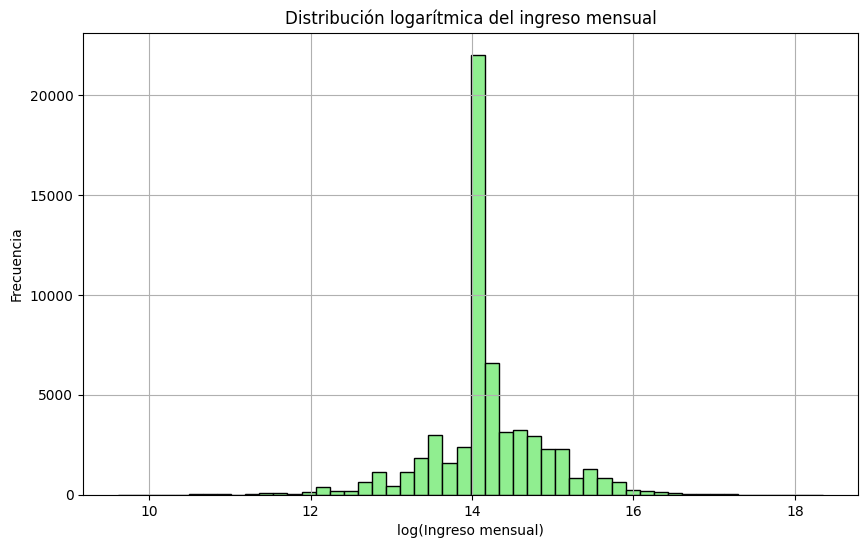

In [234]:
import numpy as np

# Crear una nueva variable de ingreso transformada
df_anual["log_ingreso_mensual"] = np.log(df_anual["ingreso_mensual"].where(df_anual["ingreso_mensual"] > 0))

# Verificamos la nueva distribución
plt.figure(figsize=(10, 6))
plt.hist(df_anual["log_ingreso_mensual"].dropna(), bins=50, color='lightgreen', edgecolor='black')
plt.title("Distribución logarítmica del ingreso mensual")
plt.xlabel("log(Ingreso mensual)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


In [236]:
print(df_anual["log_ingreso_mensual"].describe())


count    60304.000000
mean        14.182077
std          0.709624
min          9.615805
25%         13.997832
50%         14.077875
75%         14.508658
max         18.348110
Name: log_ingreso_mensual, dtype: float64


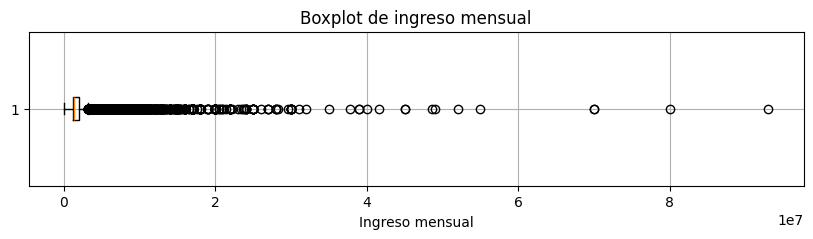

In [237]:
plt.figure(figsize=(10, 2))
plt.boxplot(df_anual["ingreso_mensual"].dropna(), vert=False)
plt.title("Boxplot de ingreso mensual")
plt.xlabel("Ingreso mensual")
plt.grid(True)
plt.show()

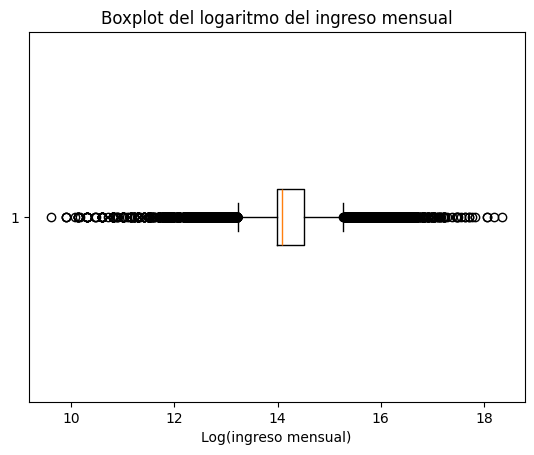

In [238]:
df_anual["log_ingreso_mensual"] = np.log(df_anual["ingreso_mensual"].replace(0, np.nan)).dropna()

plt.boxplot(df_anual["log_ingreso_mensual"].dropna(), vert=False)
plt.title("Boxplot del logaritmo del ingreso mensual")
plt.xlabel("Log(ingreso mensual)")
plt.show()